<a href="https://colab.research.google.com/github/CodingYodha/Customer-Review-Sentiment-using-LSTM-/blob/main/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/CodingYodha/Customer-Review-Sentiment-using-LSTM-.git

Cloning into 'Customer-Review-Sentiment-using-LSTM-'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 42 (delta 13), reused 21 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 13.20 MiB | 13.81 MiB/s, done.
Resolving deltas: 100% (13/13), done.


In [2]:
import pandas as pd

In [4]:
df = pd.read_csv('/content/Customer-Review-Sentiment-using-LSTM-/1429_1.csv')

<ipython-input-4-5d9b6bb20a54>:1: DtypeWarning: Columns (1,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/Customer-Review-Sentiment-using-LSTM-/1429_1.csv')


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    34660 non-null  object 
 1   name                  27900 non-null  object 
 2   asins                 34658 non-null  object 
 3   brand                 34660 non-null  object 
 4   categories            34660 non-null  object 
 5   keys                  34660 non-null  object 
 6   manufacturer          34660 non-null  object 
 7   reviews.date          34621 non-null  object 
 8   reviews.dateAdded     24039 non-null  object 
 9   reviews.dateSeen      34660 non-null  object 
 10  reviews.didPurchase   1 non-null      object 
 11  reviews.doRecommend   34066 non-null  object 
 12  reviews.id            1 non-null      float64
 13  reviews.numHelpful    34131 non-null  float64
 14  reviews.rating        34627 non-null  float64
 15  reviews.sourceURLs 

In [6]:
for col in df.columns:
  print('\n')
  print('='*75)
  print(col)
  print('='*75)
  print(df[col].value_counts())
  print('='*75)
  print('\n')



id
id
AVphgVaX1cnluZ0-DR74    10966
AVpfl8cLLJeJML43AE3S     6619
AV1YE_muvKc47QAVgpwE     5056
AV1YnRtnglJLPUi8IJmV     3176
AVqkIhwDv8e3D1O-lebb     2814
AVqVGWLKnnc1JgDc3jF1     1685
AVpjEN4jLJeJML43rpUe     1038
AVpfpK8KLJeJML43BCuD      636
AVphPmHuilAPnD_x3E5h      580
AVsRjfwAU2_QcyX9PHqe      402
AV1YnR7wglJLPUi8IJmi      372
AVqVGWQDv8e3D1O-ldFr      270
AVpidLjVilAPnD_xEVpI      256
AVqVGZNvQMlgsOJE6eUY      212
AVqkIiKWnnc1JgDc3khH      158
AVpfIfGA1cnluZ0-emyp       73
AVqVGZO3nnc1JgDc3jGK       67
AVpftoij1cnluZ0-p5n2       51
AVqkIdntQMlgsOJE6fuB       30
AVpe7AsMilAPnD_xQ78G       19
AVpfBEWcilAPnD_xTGb7       19
AVzRlorb-jtxr-f3ygvQ       16
AVpf_4sUilAPnD_xlwYV       15
AVqkIj9snnc1JgDc3khU       14
AVpfiBlyLJeJML43-4Tp       13
AVphLY7v1cnluZ0-_Ty0       13
AVpgdkC8ilAPnD_xsvyi       10
AVpf_znpilAPnD_xlvAF       10
AVpggqsrLJeJML43O5zp        8
AVzvXXwEvKc47QAVfRhx        8
AVqkIhxunnc1JgDc3kg_        7
AVzoGHhAglJLPUi8GfzY        7
AVpff7_VilAPnD_xc1E_        6
AV

In [7]:
df.columns

Index(['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.doRecommend', 'reviews.id',
       'reviews.numHelpful', 'reviews.rating', 'reviews.sourceURLs',
       'reviews.text', 'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username'],
      dtype='object')

In [8]:
columns = ['id', 'name', 'asins', 'brand', 'categories', 'keys', 'manufacturer',
       'reviews.date', 'reviews.dateAdded', 'reviews.dateSeen',
       'reviews.didPurchase', 'reviews.id',
       'reviews.numHelpful', 'reviews.sourceURLs',
       'reviews.title', 'reviews.userCity',
       'reviews.userProvince', 'reviews.username']

dfn = df.drop(columns = columns)
dfn.head(3)

,reviews.doRecommend,reviews.rating,reviews.text
0,True,5.0,This product so far has not disappointed. My c...
1,True,5.0,great for beginner or experienced person. Boug...
2,True,5.0,Inexpensive tablet for him to use and learn on...


In [9]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34660 entries, 0 to 34659
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviews.doRecommend  34066 non-null  object 
 1   reviews.rating       34627 non-null  float64
 2   reviews.text         34659 non-null  object 
dtypes: float64(1), object(2)
memory usage: 812.5+ KB


In [10]:
dfn.dropna(inplace=True)

In [11]:
dfn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34066 entries, 0 to 34624
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   reviews.doRecommend  34066 non-null  object 
 1   reviews.rating       34066 non-null  float64
 2   reviews.text         34066 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.0+ MB


In [12]:
!pip install contractions emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 12.1 MB/s eta 0:00:00


In [13]:
!pip install contractions

In [14]:
import re
import string
import numpy as np
import contractions
import emoji
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob  # Still using TextBlob for sentiment scores
import pandas as pd
import spacy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


class TextPreprocessor:
    def __init__(self, remove_stopwords=True, use_lemmatization=True):
        # Load spaCy English model
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.remove_stopwords = remove_stopwords
        self.use_lemmatization = use_lemmatization

        # Custom stopwords
        self.custom_stopwords = {'movie', 'film', 'show', 'watch', 'seen'}
        self.stop_words = self.nlp.Defaults.stop_words.union(self.custom_stopwords)

    def clean_text(self, text):
        """Basic text cleaning before spaCy processing"""
        if not isinstance(text, str):
            text = str(text)

        # Expand contractions
        text = contractions.fix(text)

        # Convert emojis to text
        text = emoji.demojize(text)

        # Remove URLs and HTML tags
        text = re.sub(r'http\S+|www\S+|https\S+|<.*?>', '', text)

        return text

    def handle_negation(self, doc):
        """Handle negation using spaCy tokens"""
        negation_tokens = {'not', 'no', 'never', 'none', "n't", 'neither', 'nor'}
        negated = []
        negate = False

        for token in doc:
            if token.lower_ in negation_tokens:
                negate = True
            elif token.is_punct:
                negate = False
            elif negate:
                negated.append(f'NOT_{token.lemma_}')
            else:
                negated.append(token.lemma_)
        return negated

    def preprocess(self, text):
        """Complete spaCy-based preprocessing pipeline"""
        try:
            # Clean text first
            text = self.clean_text(text)

            # Process with spaCy
            doc = self.nlp(text)

            # Handle negation and lemmatize
            tokens = self.handle_negation(doc)

            # Filter stopwords and punctuation
            if self.remove_stopwords:
                tokens = [
                    token for token in tokens
                    if (token.lower() not in self.stop_words) and
                       (not self.nlp.vocab[token].is_punct)
                ]

            return tokens

        except Exception as e:
            print(f"Error preprocessing text: {str(e)}")
            return []

class FeatureExtractor:
    def __init__(self, max_features=5000, ngram_range=(1, 3)):
        self.vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range,
            min_df=2,
            max_df=0.95
        )

    def fit_transform(self, texts):
        processed_texts = [' '.join(tokens) for tokens in texts]
        return self.vectorizer.fit_transform(processed_texts)

    def transform(self, texts):
        processed_texts = [' '.join(tokens) for tokens in texts]
        return self.vectorizer.transform(processed_texts)

def prepare_lstm_data(df):
    # Initialize preprocessor
    preprocessor = TextPreprocessor(remove_stopwords=True, use_lemmatization=True)

    # Preprocess texts
    print("Preprocessing texts...")
    df['processed_text'] = df['reviews.text'].apply(preprocessor.preprocess)

    # Convert tokens to strings
    df['processed_text'] = df['processed_text'].apply(lambda x: ' '.join(x))

    # Convert ratings to labels (example: 1-5 stars to binary sentiment)
    # Modify this based on your rating scale
    df['sentiment'] = df['reviews.rating'].apply(lambda x: 1 if x > 3 else 0)

    return df



In [15]:
dfn = prepare_lstm_data(dfn)

Preprocessing texts...


In [16]:
x = dfn['processed_text']
y = dfn['sentiment']

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=5000 , oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)

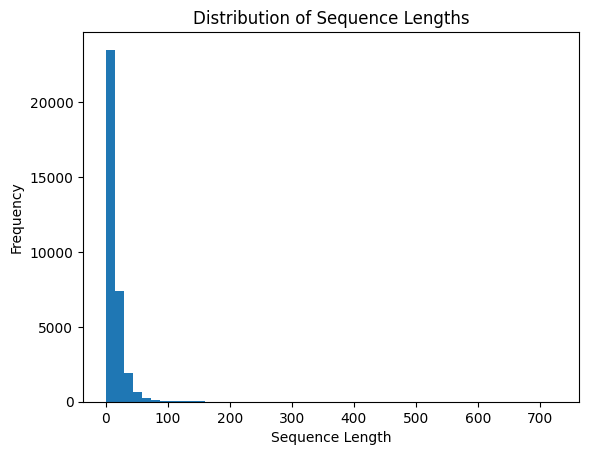

In [17]:
sequence_lengths = [len(seq.split()) for seq in dfn['processed_text']]

import matplotlib.pyplot as plt
plt.hist(sequence_lengths, bins=50)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Distribution of Sequence Lengths")
plt.show()


In [18]:
import numpy as np
sequence_lengths = [len(seq.split()) for seq in dfn['processed_text']]
max_length = int(np.percentile(sequence_lengths, 90))
print("90th Percentile Length:", max_length)


90th Percentile Length: 28


In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train_padded = pad_sequences(x_train_seq, maxlen=max_length, padding='post', truncating='post')
x_test_padded = pad_sequences(x_test_seq, maxlen=max_length, padding='post', truncating='post')

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

import numpy as np

def load_glove_vectors(glove_file_path='glove.6B.300d.txt'):
    """Loads GloVe word embeddings from a text file.

    Args:
        glove_file_path (str): Path to the GloVe embeddings file.

    Returns:
        dict: A dictionary mapping words to their embedding vectors.
    """
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Get the vocabulary size from the tokenizer
vocab_size = len(tokenizer.word_index) + 1  # Add 1 for the OOV token

# Load the GloVe embeddings
embeddings_index = load_glove_vectors()

# Create an embedding matrix with GloVe vectors for your vocabulary
embedding_matrix = np.zeros((vocab_size, 300))  # 300 is the embedding dimension
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

# Create the embedding layer
embedding_layer = Embedding(
    input_dim=vocab_size,
    output_dim=300,  # Embedding dimension (adjust as needed)
    weights=[embedding_matrix],
    trainable=False  # Freeze embeddings if desired
)

# Add the embedding layer to your model


--2025-03-11 14:11:59--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-03-11 14:11:59--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-03-11 14:11:59--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

NameError: name 'model' is not defined

In [32]:
model.add(embedding_layer)

In [33]:
model = Sequential([
    embedding_layer,  # Assuming you added the embedding layer correctly
    LSTM(64, return_sequences=False),  # Set return_sequences=True for the first LSTM layer

    # Dropout(0.3),
    # LSTM(32),  # If using another LSTM, it can now receive 3D input
    Dropout(0.3),
    Dense(1, activation='sigmoid') #The output layer should have a single neuron with a sigmoid activation
])



In [34]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,  # Wait 3 epochs after validation loss increases
    restore_best_weights=True
)

In [35]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss='binary_crossentropy',
    optimizer = Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

In [36]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(y_train),
                                                  y=y_train)
class_weights = dict(enumerate(class_weights))

In [37]:
history = model.fit(
    x_train_padded,
    y_train,
    epochs=10,
    batch_size=64,
    validation_data=(x_test_padded, y_test),
    verbose=1,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - accuracy: 0.5535 - loss: 0.6696 - val_accuracy: 0.7104 - val_loss: 0.6570
Epoch 2/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7223 - loss: 0.5557 - val_accuracy: 0.7288 - val_loss: 0.5470
Epoch 3/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7638 - loss: 0.4927 - val_accuracy: 0.7649 - val_loss: 0.4885
Epoch 4/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.7686 - loss: 0.4812 - val_accuracy: 0.8013 - val_loss: 0.4401
Epoch 5/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7846 - loss: 0.4746 - val_accuracy: 0.8102 - val_loss: 0.4234
Epoch 6/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7782 - loss: 0.4621 - val_accuracy: 0.7840 - val_loss: 0.4842
Epoch 7/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.7985 - loss: 0.4492 - val_accuracy: 0.7863 - val_loss: 0.4537
Epoch 8/10
426/426 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.7931 - loss: 0.4362 - val_accuracy: 

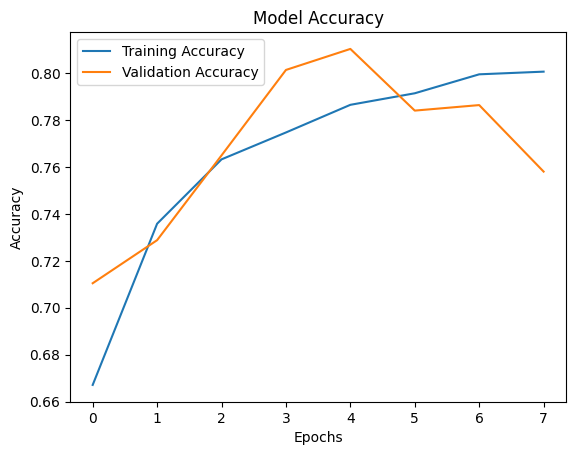

In [38]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()


In [39]:
model.save('sentiment_model.h5')
# Save tokenizer using pickle
import pickle
with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)


In [40]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle

# Load saved model and tokenizer
model = tf.keras.models.load_model('sentiment_model.h5', compile=False)
with open('tokenizer.pickle', 'rb') as f:
    tokenizer = pickle.load(f)

# Set max_length (should match what you used during training)
max_length = 28  # Adjust if necessary

# Example Amazon reviews to test
amazon_reviews = [
    "This product exceeded my expectations, absolutely fantastic!",
    "Terrible quality, it broke after one use. Would not recommend.",
    "Average experience, nothing too special about it.",
    "I love this! It has made my life so much easier. Highly recommend it.",
    "The product is ok, but shipping was extremely slow and customer service unresponsive."
]

# Preprocess: Tokenize and pad reviews
sequences = tokenizer.texts_to_sequences(amazon_reviews)
padded = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Predict sentiment
predictions = model.predict(padded)
for review, pred in zip(amazon_reviews, predictions):
    sentiment = "Positive" if pred[0] > 0.5 else "Negative"
    print(f"Review: {review}\nSentiment: {sentiment} (Score: {pred[0]:.4f})\n")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Review: This product exceeded my expectations, absolutely fantastic!
Sentiment: Positive (Score: 0.8011)

Review: Terrible quality, it broke after one use. Would not recommend.
Sentiment: Negative (Score: 0.2914)

Review: Average experience, nothing too special about it.
Sentiment: Negative (Score: 0.2662)

Review: I love this! It has made my life so much easier. Highly recommend it.
Sentiment: Positive (Score: 0.8270)

Review: The product is ok, but shipping was extremely slow and customer service unresponsive.
Sentiment: Negative (Score: 0.0926)

